#  Projeção - Integração Aprova  Digital e SEI
#### _Autor_ : Henrique Pougy

### Resumo:

        Este notebook tem por objetivo subsidiar a tomada de decisão sobre a alocação de recursos de infra-estrutura de TI para viabilizar a integração entre a ferramenta Aprova Digital - novo portal de licenciamento edilício da Prefeitura de Sâo Paulo - e o SEI, sistema de processo eletrônico do município.

        São avaliadas duas dimensões:
        
        1. Projeção da volumetria de armazenamento necessária, ao longo do período de um ano;
        2. Dimensionamento da quantidade de requisições diárias;
        
        Em ambos os casos, para construção das projeções, nos valemos de dados extraídos do sistema SELSISA. A partir de um webscrapper desenvolvido pelo autor (que não está presente neste repositório por razões de segurança), extraímos deste sistema a relação de assuntos relacionados ao licenciamento edilício protocolados na Secretaria de Licenciamento no período que vai de 01/01/2017 até o momento da extração, dia 07/07/2020. Esses dados foram então devidamente anonimizados, retendo apenas as variáveis absolutamente necessárias para a análise. Ao todo, foram processados mais de 35 mil protocolos, em um período de 4 anos, gerando uma análise bastante robusta.

### Metodologia:
    
#### Volumetria

        Para a construção do modelo preditivo para a volumetria foi empregado o método de Regressão Linear Simples. A variável independente considerada foi o número de dias passados desde 7 de julho de 2017, data de publicação do Decreto Nº 57.776, que regulamentou o novo Código de Obras do município. Como variável dependente ou "alvo", foi utilizada a quantidade acumulada de solicitações relacionadas ao licenciamento edilício protocoladas em SEL desde o dia 7 de julho de 2017.
        O modelo assim construído foi então utilizado para prever a evolução da quantidade de solicitações abertas no Aprova Digital no período de um ano após seu lançamento. A matriz resultante da previsão do modelo foi multiplicada então pelos valores escalares correspondentes, respectivamente, à volumetria média dos processos SEI da Secretaria de Licenciamento no Aprova Rápido, em bytes.
        Para facilitar a gestão dessa volumetria, a projeção foi dividida em períodos cumulativos de 30 dias, que representam a volumetria necessária prevista para cada mês, expressa em GigaBytes - possibilitando uma contratação mais precisa e eficiente.
        
#### Quantidade de Requisições

        Para modelar a quantidade de requisições, nos debruçamos sobre a série temporal que descreve a quantidade de solicitações com assuntos relacionados ao licenciamento edilício protocoladas por dia na Secretaria de Licenciamento desde 7 de julho de 2017. Identificamos que essa série temporal possui clara sazonalidade, permanecendo, com exceção de poucos outliers, em um padrão claro. Analisamos a distribuição e a testamos para normalidade, rejeitando a hipótese nula de que a distribuição não é normal com extrema significância estatística. Neste cenário, concluímos sobre a adequação de se utilizar medidas de centralidade para prever a quantidade de requisições diárias que serão realizadas pelo Aprova Digital ao SEI (especificamente, a média).
        
### Resultados:

        Nas células abaixo mostramos os resultados das projeções:

In [57]:
projecao_volumetria_mes_gb

,dias_passados_lançamento,tamanho_medio_inicial_GB,tamanho_medio_apos_analise_GB
30,30,33.422231,53.468351
60,60,66.844462,106.936701
90,90,100.266692,160.405052
120,120,133.688923,213.873402
150,150,167.111154,267.341753
180,180,200.533385,320.810104
210,210,233.955615,374.278454
240,240,267.377846,427.746805
270,270,300.800077,481.215155
300,300,334.222308,534.683506


In [58]:
quantidade_de_requisicoes

,Quantidade de Requisições
média,36.22101
25%,29.00000
75%,45.00000
max,105.00000
mediana,36.00000


## Seção 1 - Data Munging

    Nesta seção carregamos os dados para nosso ambiente de análise, os limpamos e os formatamos corretamente. Em seguida, criamos nova variáveis e fazemos agregações, gerando a base de dados sobre a qual será realizada nossa análise exploratória. Esse processo é conhecido como "data munging". 

Abaixo importamos as bibliotecas necessárias para a análise, assim como configuramos o notebook.

In [3]:
import pandas as pd
import os
from pandas.plotting import lag_plot, autocorrelation_plot
import seaborn as sns
sns.set()
%matplotlib inline

Em seguida, realizamos a leitura da fonte de dados original. 

Segue o dicionário de variáveis:

> _Assunto_ : assunto, relacionado ao licenciamento edilício, da solicitação que foi protocolada pelo munícipe (por exemplo: apostilamento de seu alvará de aprovação e execução);

> _Data inclusão_ : data em que este assunto foi incluído no processo administrativo, ou seja, data em que a solicitação protocolada pelo munícipe foi recebida pela Secretaria de Licenciamento


Após inspecionarmos o dataframe resultante, notando que ele contém colunas indesejadas ("Unnamed: 0", que corresponde ao índice do arquivo de excel), assim como data types incorretos (a coluna "Data inclusão" está como object, ou "texto", ao invés de datetime, ou "data").

Esses problemas são corrigidos em seguida.

In [4]:
df = pd.read_excel('assuntos_protocolados_2017_2020_anonimo.xlsx')

In [5]:
df.head()

,Unnamed: 0,Assunto,Data inclusão
0,0,001-0 - DIRETRIZES DE PROJETO,26/09/2017
1,1,004-1 - APOSTILAMENTO DE ALVARA DE APROVACAO D...,19/03/2019
2,2,004-5 - RECONSIDERACAO DE DESPACHO DE ALVARA D...,23/01/2019
3,3,004-1 - APOSTILAMENTO DE ALVARA DE APROVACAO D...,21/01/2019
4,4,004-1 - APOSTILAMENTO DE ALVARA DE APROVACAO D...,21/01/2019


In [6]:
pd.DataFrame(df.dtypes)

,0
Unnamed: 0,int64
Assunto,object
Data inclusão,object


Abaixo, excluímos a coluna indesejada e em seguida criamos uma nova coluna, que contém a data de protocolação do assunto com 

In [7]:
df.drop('Unnamed: 0', axis = 1, inplace = True)
df['dt_inclusao'] = pd.to_datetime(df['Data inclusão'], format = '%d/%m/%Y')

Após análise exploratória prévia, notamos que assuntos relacionados à regularização, também conhecida como "Lei da Anistia", estão presentes em nossa base de dados. Esses assuntos não comporão o escopo do Aprova Digital, portanto, são removidos da base.

In [8]:
#aqui selecionamos os assuntos que contem a palavra "regularização"
regularizacao = [assunto for assunto in df['Assunto'].unique()
                if 'REGULARIZACAO' in assunto] 

In [9]:
regularizacao

['013-0 - CERTIFICADO DE REGULARIZACAO',
 '013-5 - RECONSIDERACAO DE DESPACHO DE CERTIFICADO DE REGULARIZACAO',
 '013-1 - APOSTILAMENTO DE CERTIFICADO DE REGULARIZACAO',
 '047-5 - RECONSIDERACAO DE DESPACHO DE AUTO DE REGULARIZACAO DE PARCELAMENTO DO SOLO',
 '064-1 - APOSTILAMENTO DE AUTO DE REGULARIZACAO',
 '064-0 - AUTO DE REGULARIZACAO',
 '064-5 - RECONSIDERACAO DE DESPACHO DE AUTO DE REGULARIZACAO',
 '070-1 - APOSTILAMENTO DE AUTO DE REGULARIZACAO LEI N:13.558/2003',
 '070-5 - RECONSIDERACAO DO DESPACHO DE AUTO DE REGULARIZACAO LEI N:13.558/2003',
 '070-0 - AUTO DE REGULARIZACAO LEI N:13.558/2003']

In [10]:
#aqui filtramos o dataframe, removendo as protocolações destes assuntos
df = df[~df['Assunto'].isin(regularizacao)].copy().reset_index(drop = True) 

Caso inspecionemos os dados, notaremos que eles se iniciam em 03/01 de 2017, antes da publicação do decreto que regula o novo código de obras.
Sob outra legislação, esses assuntos não são exatamente comensuráveis aos atuais. Por isso, os removeremos.

In [11]:
df.sort_values(by = 'dt_inclusao', inplace = True)

In [12]:
df.head()

,Assunto,Data inclusão,dt_inclusao
9127,025-3 - REVALIDACAO DE ALVARA DE FUNCIONAMENTO...,03/01/2017,2017-01-03
2081,004-5 - RECONSIDERACAO DE DESPACHO DE ALVARA D...,03/01/2017,2017-01-03
17456,048-1 - APOSTILAMENTO DE ALVARA DE APROVACAO E...,03/01/2017,2017-01-03
17447,048-0 - ALVARA DE APROVACAO E EXECUCAO DE EDIF...,03/01/2017,2017-01-03
3593,007-0 - ALVARA DE EXECUCAO DE EDIFICACAO NOVA,03/01/2017,2017-01-03


In [13]:
data_public = pd.to_datetime('07/07/2017') #data da publicacao do decreto

In [14]:
periodo_correto = df['dt_inclusao'] >= data_public

In [15]:
df = df[periodo_correto].reset_index(drop=True) #aqui filtramos o dataframe o periodo correto

Ordenamos os dados novamente pela data de inclusao da solicitação no processo administrativo e notamos que agora o período está correto.

In [16]:
df.sort_values(by='dt_inclusao', inplace = True)
df.head() 

,Assunto,Data inclusão,dt_inclusao
0,019-0 - CERTIFICADO DE SEGURANCA,07/07/2017,2017-07-07
26,048-5 - RECONSIDERACAO DESPACHO DE ALVARA DE A...,07/07/2017,2017-07-07
27,061-5 - RECONSIDERACAO DE DESPACHO DE ALVARA D...,07/07/2017,2017-07-07
28,048-5 - RECONSIDERACAO DESPACHO DE ALVARA DE A...,07/07/2017,2017-07-07
29,022-3 - REVALIDACAO DO ALVARA DE FUNCIONAMENTO...,07/07/2017,2017-07-07


Agora a base de dados está "limpa". No entanto, para que possamos realizar nossa análise, será necessário ainda agrupar a quantidade de protocolações por dia - assim saberemos quantas solicitações com assuntos relacionados ao licenciamento foram protocolados por dia em SEL. Esse processo é realizado nas células abaixo. 

In [17]:
#criamos uma coluna com o nome "quantidade", iniciada em 1, pois neste formato cada linha equivale a uma protocolação
df['quantidade'] = 1 

In [18]:
protocolacao_assuntos = df.groupby('dt_inclusao').count()['quantidade'] #agrupamos pela quantidade de protocolacoes por dia

In [19]:
pd.DataFrame(protocolacao_assuntos).head()

,quantidade
dt_inclusao,
2017-07-07,47
2017-07-11,49
2017-07-12,29
2017-07-13,34
2017-07-14,43


Com isso, temos nossos dados para a análise.

## Seção 2 - Análise exploratória e Feature Engineering

        Nesta seção exploraremos os dados obtidos e, em seguida, criaremos novas variáveis.
        
        Iniciaremos por visualizar os dados gerados na seção anterior: o gráfico a seguir plota a quantidade de solicitações com assuntos relacionadas protocoladas em SEL em um dia (eixo Y) em função do dia do ano, em ordem crescente (eixo X).
        
        Como podemos notar, há sazonalidade nos dados, que parecem seguir um mesmo padrão ao longo dos quatro anos, com exceção de dois fatos notáveis:
        
        - Um pico pontual de solicitações protocoladas entre o final de 2018 e o início de 2019.
        - Uma queda na quantidade geral de solicitações em 2020.


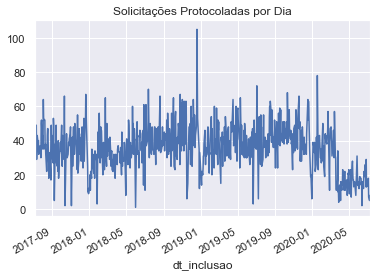

In [20]:
protocolacao_assuntos.plot(title = 'Solicitações Protocoladas por Dia')

Caso ordenemos os dias pela quantidade de solicitações protocoladas, e inspecionemos os dados, podemos notar que o pico entre o final de 2018 e início de 2019 se trata do dia 19/12/2020, provavelmente motivado pela entrada da secretaria em recesso de natal.

De todo modo, percebemos que ele é isolado, sendo que os outros dias com maiores quantidade de solicitação permanecem no padrão geral dos dados (menor que 80 solicitações).

In [21]:
pd.DataFrame(protocolacao_assuntos).sort_values(by='quantidade', ascending = False).head(10)

,quantidade
dt_inclusao,
2018-12-19,105
2018-12-20,79
2020-01-17,78
2019-07-03,72
2018-07-13,70
2019-10-11,68
2018-10-25,67
2017-12-20,67
2019-11-18,66


Outra forma de conceber esses dados, mais adequada ao problema que buscamos modelar, seria observá-los como valores acumulados.

Nas células abaixo, construímos outra matriz contendo os valores acumulados por dia, e plotamos o gráfico que mostra a linha de tendência.

In [22]:
series = {}
valor_acumul = 0
for i, val in zip(protocolacao_assuntos.index, protocolacao_assuntos.values):
    valor_acumul+=val
    series[i] = valor_acumul

In [23]:
protocol_assuntos_acumul = pd.Series(series)

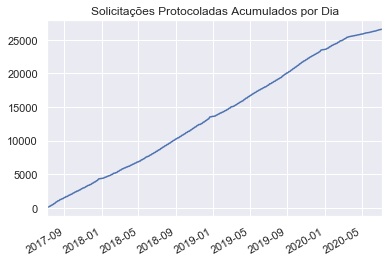

In [24]:
protocol_assuntos_acumul.plot(title = 'Solicitações Protocoladas Acumulados por Dia')

Como podemos ver no gráfico acima, o pico de solicitações em dezembro de 2018 não afetou a tendência geral.

No entanto, há sim uma tendência de queda, que parece estar alcançando um platô, em 2020.

Esta tendência pode ser explicada pela migração de certos assuntos para o Aprova Rápido.

Além disso, podemos notar que estes dados - que indicam a tendência de crescimento da quantidade acumulada de solicitações relacionadas ao licenciamento edilício em SEL - são muito mais significativos em relação ao problema que queremos modelar do que os dados anteriores, que nos permitem ver a sazonabilidade na protocolação de solicitação.

Pois uma vez realizadas no Aprova Digital, as protocolação serão armazenadas em seu banco de dados. Essa tendência cumulativa linear positiva é a mesma que seguirá a volumetria de armazenamento do sistema.

Neste sentido - e para que melhor possamos modelar o problema - na célula abaixo construímos uma nova matriz, que conterá duas dimensões:

1. A quantidade de dias que se passaram desde a publicação do decreto que regula o código de obras;
2. A quantidade acumulada de solicitações relacionadas ao licenciamento edilício protocoladas na secretaria;

In [25]:
solicit_acumul = []
dias_passados = []

valor_acumulado = 0
for dia, quantidade in zip(protocolacao_assuntos.index, protocolacao_assuntos.values):
    
    qt_dias = dia - data_public #variavel definida anteriormente
    dias_passados.append(qt_dias.days)
    
    valor_acumulado += quantidade
    solicit_acumul.append(valor_acumulado)

df_treino = pd.DataFrame(data = zip(dias_passados, solicit_acumul),
            columns = ['dias_passados', 'solicitacoes_acumuladas'])

Após a construção da nova matriz, a inspecionamos.

Em seguida, plotamos a relação entre ambas as dimensões. 

A inspeção visual permite averiguar que há bastante correlação entre as variáveis, o que é confirmado pelo gráfico de dispersão. Essa correlação linear positiva é esperada, pois as solicitações seguem um padrão sazonal claro (visto anteriormente) e a natureza do problema é cumulativa.

In [26]:
df_treino.head()

,dias_passados,solicitacoes_acumuladas
0,0,47
1,4,96
2,5,125
3,6,159
4,7,202


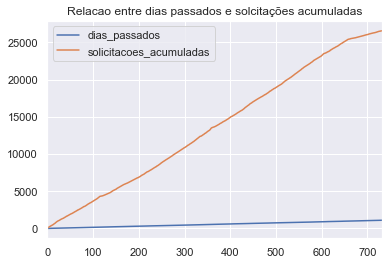

In [27]:
df_treino.plot(title= 'Relacao entre dias passados e solcitações acumuladas')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


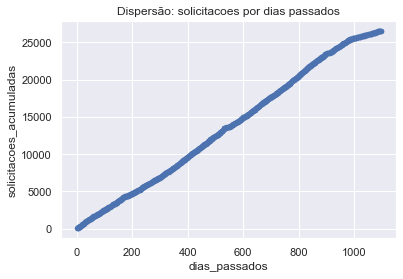

In [28]:
df_treino.plot.scatter('dias_passados', 'solicitacoes_acumuladas', title = 'Dispersão: solicitacoes por dias passados')

# Seção 3 - Modelagem

As visualizações presentes na seção anterior indicaram haver correlação linear positiva entre ambas as variáveis. Essa correlação é confirmada pela matriz de correlação abaixo:

In [29]:
df_treino.corr()

,dias_passados,solicitacoes_acumuladas
dias_passados,1.0000,0.9989
solicitacoes_acumuladas,0.9989,1.0000


Estas caraterísticas mostram que o problema pode ser adequadamente modelado a partir de uma Regressão Linear Simples.

Nas células a seguir, realizamos essa modelagem e apresentamos as informações estatísticas do modelo gerado.

In [30]:
from statsmodels.api import OLS

In [31]:
model = OLS(df_treino.solicitacoes_acumuladas, df_treino.dias_passados)

In [32]:
res = model.fit()

In [33]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                   
============================================================================================
Dep. Variable:     solicitacoes_acumuladas   R-squared (uncentered):                   0.999
Model:                                 OLS   Adj. R-squared (uncentered):              0.999
Method:                      Least Squares   F-statistic:                          1.043e+06
Date:                     Thu, 23 Jul 2020   Prob (F-statistic):                        0.00
Time:                             10:58:26   Log-Likelihood:                         -5471.3
No. Observations:                      733   AIC:                                  1.094e+04
Df Residuals:                          732   BIC:                                  1.095e+04
Df Model:                                1                                                  
Covariance Type:                 nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
dias_passados    25.2309      0.025   1021.389      0.000      25.182      25.279
==============================================================================
Omnibus:                       25.384   Durbin-Watson:                   0.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               19.047
Skew:                           0.296   Prob(JB):                     7.31e-05
Kurtosis:                       2.477   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Como era de se espear, pela natureza cumulativa e linear do problema, o modelo teve sucesso.

O R-Quadrado é extremamente satisfatório e a variável dependente é estatísticamente significanto, com um erro-padrão baixo e um P-valor menor que 0.005.

Abaixo, salvamos o coeficiente Beta, de valor aprox. 25.1 e já apresentado no summary acima, em uma variável "coef".

In [34]:
coef = res.params[0]
print(coef)

25.230920835005755


Em conclusão, nosso modelo nos mostra que, para cada dia que se passa, a tendência é que sejam protocoladas 25 novas solicitações relacionadas ao licenciamento edilício em SEL.

Notem que esse coeficiente é muito mais robusto do que simplesmente projetar a média de protocolações diárias, que nos levaria a um erro para cima bastante elevado:

In [35]:
protocolacao_assuntos.mean()

36.22100954979536

## Seção 4 - Aplicação do Modelo

        Nesta seção aplicaremos o modelo desenvolvido na seção anterior ao nosso problema concreto: a análise de impacto da integração entre o Aprova Digital e o SEI. 
        
        A partir do coeficiente obtido, podemos projetar a taxa de crescimento das solicitações abertas no Aprova Digital no período de um ano. A matriz resultante dessa projeção será então multiplicada por um escalar, correspondente ao tamanho médio, em bytes, dos processos SEI de SEL no Aprova Rápido. Este indicador é um bom proxy para o tamanho que os processos SEI gerados pelo Aprova Digital ocuparão, pois também dizem respeito a processos SEI relacionados ao licenciamento edilício e já possuem uma base histórica considerável. 
        
        Os dados, fornecidos a nós pelo sr. Pedro Luiz Ferreira da Fonseca, servidor de  SEL, são os seguintes:
        
        * Processos SEI quando protocolados, antes da análise e junções: 47.411.200 bytes em média;
        
        * Processos SEI após análise e junções: 75.847.680 bytes em média;
        
        A matriz resultante desta projeção será então subdividida em períodos de 30 dias, gerando uma projeção mensal (e não diária), mais adequada ao planejamento contratual e às formas de gestão de armazenamento utilizadas pela PRODAM, que não dispõe, salvo engano, de servers cloud auto-escaláveis.
        
        Por fim, voltaremos ao dados de protocolações diárias, para mensurar a quantidade de requisições diária feitas pelo Aprova Digital que pode ser esperada pelo SEI.
        

Abaixo construímos um array (ou matriz 1 x n) com 365 itens, de 0 a 364, que corresponde à quantidade de dias passados em um ano.

O array precisa começar em 0 pois nosso modelo teve como variável dependente os "dias passados desde a publicação do novo código de obras". Nesta projeção, o evento inicial, sobre o qual se conta quantos dias se passaram, pode ser considerado o lançamento do Aprova Digital.


In [36]:
dias_passados_lançamento = [i for i in range(365)]

Agora, criamos uma nova matriz 3 x 365, que contém como colunas as seguintes variáveis:

    1. Dias passados desde o lançamento do Aprova Digital;
    2. Projeção, em bytes, da volumetria de processos considerando apenas a protocolação inicial;
    3. Projeção, em bytes, da volumetria de processos considerando a subida ao SEI das junções e análise;
    


In [37]:
tamanho_medio_inicial = 47411200
tamamho_medio_apos_analise = 75847680

matriz = {
    'dias_passados_lançamento' : [],
    'tamanho_medio_inicial' : [],
    'tamanho_medio_apos_analise' : []
}

for dias in dias_passados_lançamento:
    
    t_inicial = (coef * dias) * tamanho_medio_inicial
    t_analise = coef * dias * tamamho_medio_apos_analise
    
    matriz['dias_passados_lançamento'].append(dias)
    matriz['tamanho_medio_inicial'].append(t_inicial)
    matriz['tamanho_medio_apos_analise'].append(t_analise)
    
projecao_volumetria = pd.DataFrame(matriz)

projecao_volumetria.head()

,dias_passados_lançamento,tamanho_medio_inicial,tamanho_medio_apos_analise
0,0,0.000000e+00,0.000000e+00
1,1,1.196228e+09,1.913707e+09
2,2,2.392456e+09,3.827414e+09
3,3,3.588685e+09,5.741120e+09
4,4,4.784913e+09,7.654827e+09


Para facilitar a gestão, utilizaremos a quantidade em gigabytes.

In [38]:
gigabyte_to_byte = 1024**3

In [39]:
projecao_volumetria['tamanho_medio_inicial_GB'] = projecao_volumetria['tamanho_medio_inicial']/gigabyte_to_byte
projecao_volumetria['tamanho_medio_apos_analise_GB'] = projecao_volumetria['tamanho_medio_apos_analise']/gigabyte_to_byte

In [40]:
projecao_volumetria.head()

,dias_passados_lançamento,tamanho_medio_inicial,tamanho_medio_apos_analise,tamanho_medio_inicial_GB,tamanho_medio_apos_analise_GB
0,0,0.000000e+00,0.000000e+00,0.000000,0.000000
1,1,1.196228e+09,1.913707e+09,1.114074,1.782278
2,2,2.392456e+09,3.827414e+09,2.228149,3.564557
3,3,3.588685e+09,5.741120e+09,3.342223,5.346835
4,4,4.784913e+09,7.654827e+09,4.456297,7.129113


Agora, selecionamos os períodos de 30 em 30 dias. A projeção final 

In [41]:
fim_30_dias = [i for i in range(30, 365, 30)]

projecao_volumetria_mes = projecao_volumetria.iloc[fim_30_dias]

Geramos então o arquivo final de projecao, contendo apenas as colunas de dias passados desde o lançamento e as projeções em GB.

E, por fim, plotamos as linhas de tendência.

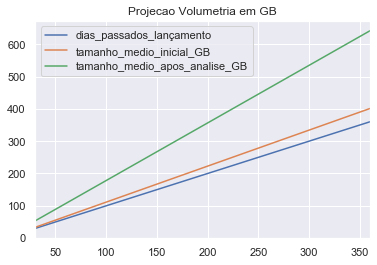

In [42]:
projecao_volumetria_mes_gb = projecao_volumetria_mes[['dias_passados_lançamento', 'tamanho_medio_inicial_GB', 
                                                      'tamanho_medio_apos_analise_GB']]

projecao_volumetria_mes_gb.plot(title = 'Projecao Volumetria em GB')

In [43]:
projecao_volumetria_mes_gb.to_excel('Projecao_Volumetria_Aprova_SEI_H_Pougy.xlsx') #aqui salvamos o arquivo final com a projeção

#### Quantidade de requisições

Agora retornaremos aos dados de protocolações diárias para mensurar a quantidade de requisições.

O Aprova Digital está configurado para criar um processo SEI contendo os dados da solicitação feita pelo munícipe/interessado, registrando-os no sistema de processo administrativo eletrônico oficial do município.

Desse modo, podemos utilizar o mesmo padrão de solicitações recebido por SEL ao longo dos últimos 4 anos para gerar essa previsão.

Retornamos ao gráfico apresentado na análise exploratória:

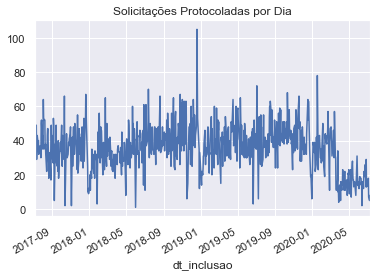

In [44]:
protocolacao_assuntos.plot(title = 'Solicitações Protocoladas por Dia')

Como vimos anteriormente, esses dados apresentam clara sazonalidade e se mantém em uma linha de tendência estável (caso contrário, nosso modelo de crescimento lienar não teria tido boa performance). Há, no entanto, alguns outliers, um deles bastante evidente, já singularizado anteriormente.

Uma boa maneira de visualizar essa situação é o boxplot.

Text(0.5, 1.0, 'Boxplot - Protocolações Diárias')

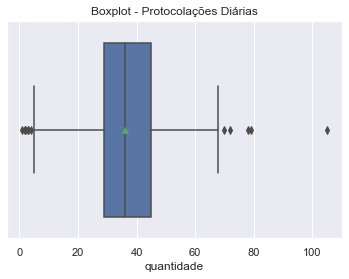

In [45]:
sns.boxplot(protocolacao_assuntos, showmeans=True, orient = 'h').set_title('Boxplot - Protocolações Diárias')

O boxplot mostra então o mesmo padrão de variação que vemos nos dados brutos: variando entre 70 e menos que 10 solicitações, com uma média em torno de 40 solicitações por dia.

Como vemos abaixo, a distribuição se assemelha de fato a uma distribuição normal:

Text(0.5, 1.0, 'Distribuição - protocolações diárias')

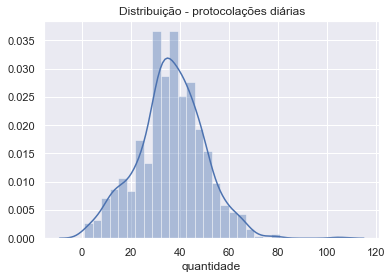

In [46]:
sns.distplot(protocolacao_assuntos).set_title('Distribuição - protocolações diárias')

Abaixo realizamos um teste de normalidade para validar essa hipótese.

Com um bom p-valor (<0.005), podemos rejeitar a hipótese nula (de que a distribuição não é normal) com extrema significância estatística.

In [47]:
from scipy.stats import normaltest

In [48]:
print(normaltest(protocolacao_assuntos))

NormaltestResult(statistic=10.746898934221639, pvalue=0.004638104694931779)


Deste modo, justifica-se o uso de estatísticas descritivas simples para realizar a projeção.

Abaixo, visualizamos essas estatísticas.

In [49]:
desc = pd.DataFrame(protocolacao_assuntos.describe())

In [50]:
desc

,quantidade
count,733.000000
mean,36.221010
std,13.645502
min,1.000000
25%,29.000000
50%,36.000000
75%,45.000000
max,105.000000


Para parametrizar o balanceamento de carga, achamos mais adequado utilizar as medidas de média, 1º quartil, 3º quartil e máxima.

A elas, acrescentamos também a mediana, que é bem próxima da média.

Geramos mais um arquivo com esses dados e finalizamos esse report.

In [51]:
quantidade_de_requisicoes = desc.loc[['mean', '25%', '75%', 'max']].rename({'quantidade' : 'Quantidade de Requisições'}, axis = 1).rename({'mean' : 'média'})

In [52]:
mediana  = protocolacao_assuntos.median()

In [53]:
quantidade_de_requisicoes.loc['mediana'] = mediana

In [54]:
quantidade_de_requisicoes

,Quantidade de Requisições
média,36.22101
25%,29.00000
75%,45.00000
max,105.00000
mediana,36.00000


In [56]:
quantidade_de_requisicoes.to_excel('Previsao_Quantidade_Requisicoes.xlsx')